In [ ]:
!pip install pyscipopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 33.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches



Liczba turbin dla wyżarzania: 89


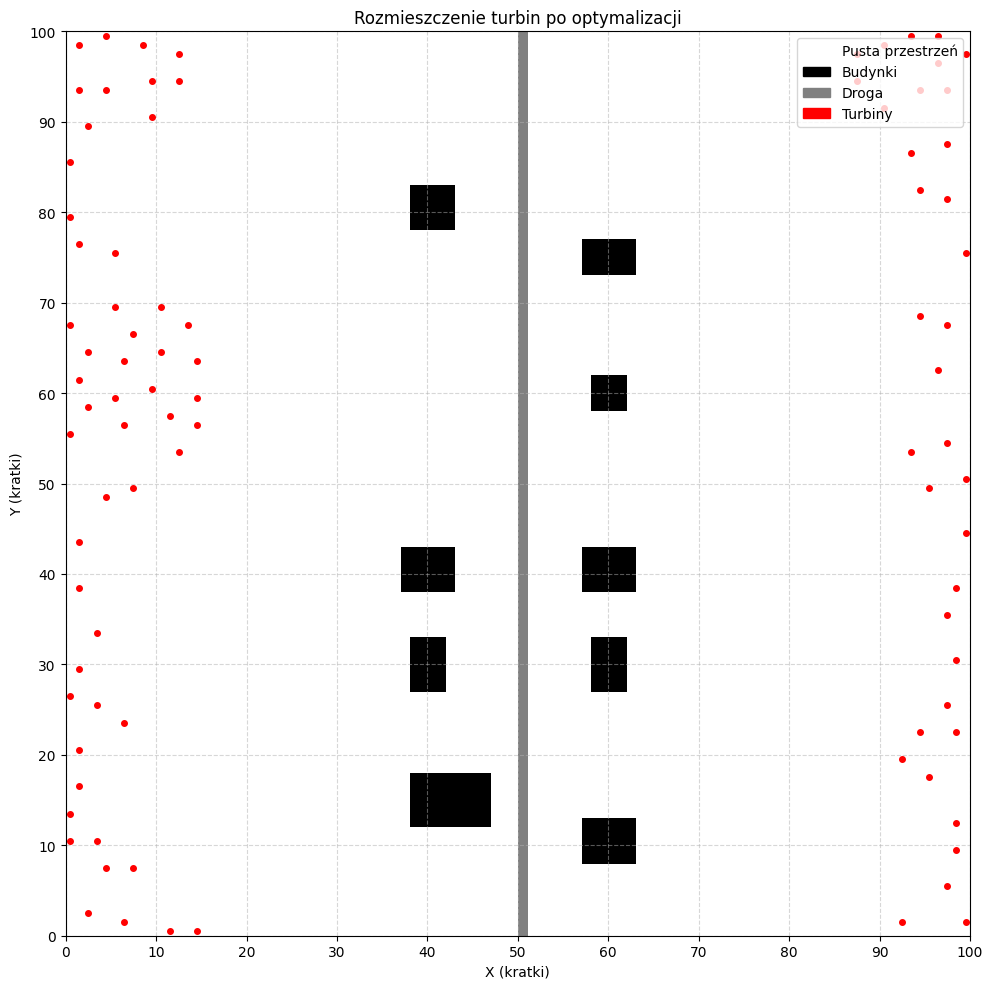

In [ ]:

n = 100
KRATKA_M = 20  # 1 kratka = 20 m

D_MIN_M = 50
BUFOR_M = 700
DROGA_SZER_M = 5

d_min_kratki = int(np.ceil(D_MIN_M / KRATKA_M))
bufor_kratki = max(1, round(BUFOR_M / KRATKA_M))
droga_szer_kratki = max(1, round(DROGA_SZER_M / KRATKA_M))

siatka = np.zeros((n, n))

def dodaj_prostokat(sr, sc, wys, szer, kod=1):
    r_start = max(0, sr - wys // 2)
    r_end = min(n, sr + (wys + 1) // 2)
    c_start = max(0, sc - szer // 2)
    c_end = min(n, sc + (szer + 1) // 2)
    siatka[r_start:r_end, c_start:c_end] = kod


for i in range(n):
    dodaj_prostokat(i, n // 2, 1, droga_szer_kratki, kod=2)

budynki_m = [
    ((300, 850), (120, 180)),
    ((1600, 800), (100, 100)),
    ((1500, 1200), (80, 120)),
    ((1200, 1200), (90, 90)),
    ((200, 1200), (100,120)),
    ((600, 800), (120, 80)),
    ((800, 800), (100, 120)),
    ((600, 1200), (120, 80)),
    ((800, 1200), (100, 120)),
]

for (sr_m, sc_m), (wys_m, szer_m) in budynki_m:
    sr = sr_m // KRATKA_M
    sc = sc_m // KRATKA_M
    wys = max(1, wys_m // KRATKA_M)
    szer = max(1, szer_m // KRATKA_M)
    dodaj_prostokat(sr, sc, wys, szer, kod=1)


przeszkody = (siatka != 0)
bufor_mask = binary_dilation(przeszkody, iterations=bufor_kratki)
puste_pola = [(i, j) for i in range(n) for j in range(n) if not bufor_mask[i, j]]


def odleglosc_w_kratkach(p1, p2):
    i1, j1 = p1
    i2, j2 = p2
    return np.hypot(i1 - i2, j1 - j2)

def ocena(turbiny):
    wynik = []
    for t in turbiny:
        if all(odleglosc_w_kratkach(t, istniejąca) >= d_min_kratki for istniejąca in wynik):
            wynik.append(t)
    return wynik

def wyzarzanie(puste_pola, T0=500, chłodzenie='exp', m_n=10, seed=None):
    if seed is not None:
        random.seed(seed)
    obecne = []
    najlepsze = []
    T = T0
    epoka = 0
    while T > 0.1:
        for _ in range(m_n):
            kandydat = obecne.copy()
            if len(obecne) < 20:
                weights = [0.8, 0.15, 0.05]
            else:
                weights = [0.4, 0.4, 0.2]
            operacja = random.choices(['dodaj', 'zamień', 'usuń'], weights=weights, k=1)[0]
            if operacja == 'dodaj' and len(kandydat) < len(puste_pola):
                nowa = random.choice(puste_pola)
                if all(odleglosc_w_kratkach(nowa, t) >= d_min_kratki for t in kandydat):
                    kandydat.append(nowa)
            elif operacja == 'zamień' and kandydat:
                i = random.randint(0, len(kandydat) - 1)
                nowa = random.choice(puste_pola)
                if all(odleglosc_w_kratkach(nowa, t) >= d_min_kratki for j, t in enumerate(kandydat) if j != i):
                    kandydat[i] = nowa
            elif operacja == 'usuń' and kandydat:
                i = random.randint(0, len(kandydat) - 1)
                kandydat.pop(i)

            poprawne = ocena(kandydat)
            if len(poprawne) >= len(najlepsze) or random.random() < np.exp((len(poprawne) - len(najlepsze)) / T):
                obecne = poprawne
                if len(poprawne) > len(najlepsze):
                    najlepsze = poprawne
        epoka += 1
        if chłodzenie == 'exp':
            T *= 0.95
        elif chłodzenie == 'rec':
            T = T0 / (1 + epoka)
        elif chłodzenie == 'log':
            T = T0 / np.log(epoka + 2)
        elif chłodzenie == 'lin':
            T = T0 - epoka * 5
    return najlepsze

#funkcja wyżarzania
turbiny = wyzarzanie(puste_pola, T0=500, chłodzenie='exp', m_n=10, seed=42)


cmap = ListedColormap(["white", "black", "gray"])
plt.figure(figsize=(10, 10))
plt.imshow(siatka, cmap=cmap, origin='lower', extent=[0, n, 0, n])
for i, j in turbiny:
    plt.plot(j + 0.5, i + 0.5, 'ro', markersize=4)

plt.title("Rozmieszczenie turbin po optymalizacji")
legend = [
    mpatches.Patch(color="white", label="Pusta przestrzeń"),
    mpatches.Patch(color="black", label="Budynki"),
    mpatches.Patch(color="gray", label="Droga"),
    mpatches.Patch(color="red", label="Turbiny")
]
plt.legend(handles=legend, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(0, n + 1, 10))
plt.yticks(np.arange(0, n + 1, 10))
plt.xlabel("X (kratki)")
plt.ylabel("Y (kratki)")
plt.tight_layout()
plt.show()

